# Data 512 Homework 1 - Article Page Views API
This notebook illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API).  The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), is provided in the link.
## License
This code developed by referring to an example developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024


In [14]:
#
# These are standard python modules
import pandas as pd
import os
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import matplotlib.pyplot as plt

Initiating variables

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<smohan5@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}


# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2023040100"    # this is likely the wrong end date
}

# Templates for Mobile App and Mobile web from the desktop template.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP["access"] = "mobile-app"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB["access"] = "mobile-web"

Below are functions to create json files and write the response into the json files.

In [3]:
# Create filenames using start and end dates in the format YYYYMM
start_date = "201507"
end_date = "202409"

# Filename names
desktop_views_file = f"rare-disease_monthly_desktop_{start_date}-{end_date}.json"
mobile_views_file = f"rare-disease_monthly_mobile_{start_date}-{end_date}.json"
cumulative_views_file = f"rare-disease_monthly_cumulative_{start_date}-{end_date}.json"

def create_directory(target_path):
    # Check if the directory already exists
    if not os.path.exists(target_path):
        try:
            # Attempt to create the directory
            os.makedirs(target_path)
        except Exception as e:
            print("Unable to create path" + target_path)
            print(e)

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [4]:
#########
#
#    Procedures/Functions for Data Aquisition
#

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


def write_to_file(json_data, filename, mode = "a+"):
    try:
        with open(filename, mode) as f:
            json.dump(json_data, f, ensure_ascii=False)
    except Exception as e:
        print(e)

In the below code, we use the API call function to request page view data and store them in the json files

In [6]:
disease_list = pd.read_csv("rare-disease_cleaned.AUG.2024.csv")

desktop_views = {}
mobile_views = {}
cumulative_views = {}

for index, row in disease_list.iterrows():

    # Fetch article title from dataframe
    article_title = row["disease"]
    print("Getting pageview data for disease:", article_title, ", index:", index)

    # Fetch data on desktop views for the article
    # Convert dataframe back to JSON Array, and add it to the desktop_views dictionary with article title as the key
    desktop_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    desktop_views_per_title = desktop_views_per_title["items"]
    desktop_views_df = pd.DataFrame(desktop_views_per_title)
    desktop_views_df = desktop_views_df.drop('access', axis=1)
    desktop_views[article_title] = json.loads(desktop_views_df.to_json(orient = "records"))

    # Fetch data on Mobile App views for the article
    mobile_app_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    mobile_app_views_per_title = mobile_app_views_per_title["items"]
    mobile_app_views_df = pd.DataFrame(mobile_app_views_per_title)

    # Fetch data on Mobile Web views for the article
    mobile_web_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    mobile_web_views_per_title = mobile_web_views_per_title["items"]
    mobile_web_views_df = pd.DataFrame(mobile_web_views_per_title)

    # Merge the Mobile App and Mobile web based on the article name and timestamp. sum the views
    mobile_views_df = pd.merge(mobile_app_views_df, mobile_web_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    mobile_views_df["views"] = mobile_views_df["views_x"] + mobile_views_df["views_y"]
    mobile_views_df = mobile_views_df.drop(['access_x','access_y', "views_x", "views_y"], axis=1)
    mobile_views[article_title] = json.loads(mobile_views_df.to_json(orient = "records"))

    # For calculating cumulative views of article, we need to sum each articles monthly views for desktop and mobile.
    # To facilitate this, merge the dataframes containing desktop views and mobile views based on the article name and timestamp
    cumulative_views_df = pd.merge(desktop_views_df, mobile_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    cumulative_views_df["views"] = cumulative_views_df["views_x"] + cumulative_views_df["views_y"]
    cumulative_views_df = cumulative_views_df.drop(["views_x", "views_y"], axis=1)
    cumulative_views[article_title] = json.loads(cumulative_views_df.to_json(orient = "records"))


    print("--------")


Getting pageview data for disease: Klinefelter syndrome , index: 0
--------
Getting pageview data for disease: Aarskog–Scott syndrome , index: 1
--------
Getting pageview data for disease: Abetalipoproteinemia , index: 2
--------
Getting pageview data for disease: MT-TP , index: 3
--------
Getting pageview data for disease: Ablepharon macrostomia syndrome , index: 4
--------
Getting pageview data for disease: Acanthocheilonemiasis , index: 5
--------
Getting pageview data for disease: Acanthosis nigricans , index: 6
--------
Getting pageview data for disease: Aceruloplasminemia , index: 7
--------
Getting pageview data for disease: Megaesophagus , index: 8
--------
Getting pageview data for disease: Achard–Thiers syndrome , index: 9
--------
Getting pageview data for disease: Achondrogenesis , index: 10
--------
Getting pageview data for disease: Achondroplasia , index: 11
--------
Getting pageview data for disease: Dwarfism , index: 12
--------
Getting pageview data for disease: Osteo

# New Section

Store Dictionaries to json file

In [7]:
target_folder = "fetched_data"
create_directory(target_folder)

write_to_file(desktop_views, filename=f"{target_folder}/{desktop_views_file}", mode="w+")
write_to_file(mobile_views, filename=f"{target_folder}/{mobile_views_file}", mode="w+")
write_to_file(cumulative_views, filename=f"{target_folder}/{cumulative_views_file}", mode="w+")

# Data Analysis and Visualisation

For the purpose of analysis, I have created dataframes from the dictionaries by flattening them.

In [9]:
cumulative_list = []
for name, monthly_data in cumulative_views.items():
    for month in monthly_data:
        cumulative_list.append({
            "name": name,
            "timestamp": month["timestamp"],
            "views": month["views"]
        })

# Convert to a Pandas DataFrame
cumulative_df = pd.DataFrame(cumulative_list)
cumulative_df['timestamp'] = pd.to_datetime(cumulative_df['timestamp'], format='%Y%m%d%H')

# Flatten desktop data
desktop_list = []
for name, monthly_data in desktop_views.items():
    for month in monthly_data:
        desktop_list.append({
            "name": name,
            "timestamp": month["timestamp"],
            "views": month["views"]
        })

# Convert to a Pandas DataFrame
desktop_df = pd.DataFrame(desktop_list)
desktop_df['timestamp'] = pd.to_datetime(desktop_df['timestamp'], format='%Y%m%d%H')


# Flatten mobile data
mobile_list = []
for name, monthly_data in mobile_views.items():
    for month in monthly_data:
        mobile_list.append({
            "name": name,
            "timestamp": month["timestamp"],
            "views": month["views"]
        })

# Convert to a Pandas DataFrame
mobile_df = pd.DataFrame(mobile_list)
mobile_df['timestamp'] = pd.to_datetime(mobile_df['timestamp'], format='%Y%m%d%H')

In [10]:
print(cumulative_df.shape)
print(desktop_df.shape)
print(mobile_df.shape)


(161259, 3)
(161259, 3)
(161259, 3)


## Analysis 1:
Maximum Average and Minimum Average - The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

The average monthly views for desktop and mobile and calculated, from this we then take the highest and lowest values and then plot the time series graph for these.

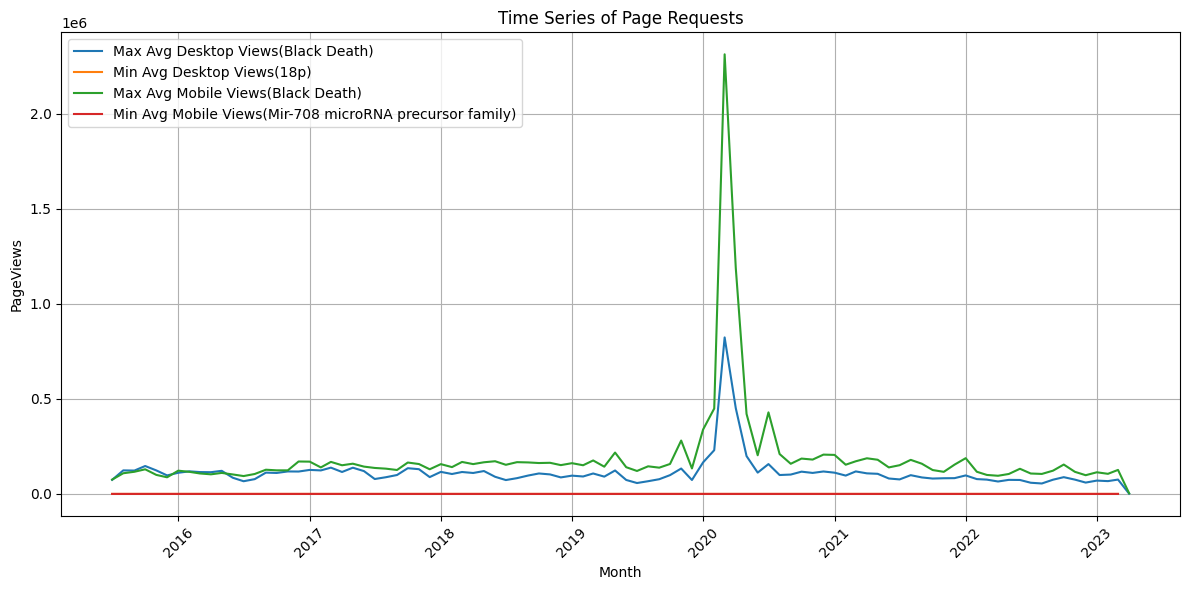

<Figure size 640x480 with 0 Axes>

In [20]:
# Calculate average monthly page requests for desktop and mobile access
desktop_avg = desktop_df.groupby("name")["views"].mean()
mobile_avg = mobile_df.groupby("name")["views"].mean()

# Find articles with highest and lowest average monthly page requests
max_desktop_article = desktop_avg.idxmax()
min_desktop_article = desktop_avg.idxmin()
max_mobile_article = mobile_avg.idxmax()
min_mobile_article = mobile_avg.idxmin()

# Filter data for these articles
max_desktop_data = desktop_df[desktop_df["name"] == max_desktop_article]
min_desktop_data = desktop_df[desktop_df["name"] == min_desktop_article]
max_mobile_data = mobile_df[mobile_df["name"] == max_mobile_article]
min_mobile_data = mobile_df[mobile_df["name"] == min_mobile_article]

# Sort the data frames by timestamp
max_desktop_data = max_desktop_data.sort_values(by="timestamp")
min_desktop_data = min_desktop_data.sort_values(by="timestamp")
max_mobile_data = max_mobile_data.sort_values(by="timestamp")
min_mobile_data = min_mobile_data.sort_values(by="timestamp")

# Create the time series graph
plt.figure(figsize=(12, 6))
plt.plot(max_desktop_data["timestamp"], max_desktop_data["views"], label=f"Max Avg Desktop Views({max_desktop_article})")
plt.plot(min_desktop_data["timestamp"], min_desktop_data["views"], label=f"Min Avg Desktop Views({min_desktop_article})")
plt.plot(max_mobile_data["timestamp"], max_mobile_data["views"], label=f"Max Avg Mobile Views({max_mobile_article})")
plt.plot(min_mobile_data["timestamp"], min_mobile_data["views"], label=f"Min Avg Mobile Views({min_mobile_article})")
plt.xlabel("Month")
plt.ylabel("PageViews")
plt.title("Time Series of Page Requests")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('MaximumMinimumAverage.png')

## Analysis 2:
Top 10 Peak Page Views - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

Here I have started by finding the month with highest page views for each article and then sort articles by peak page views and then plot the time series graph.

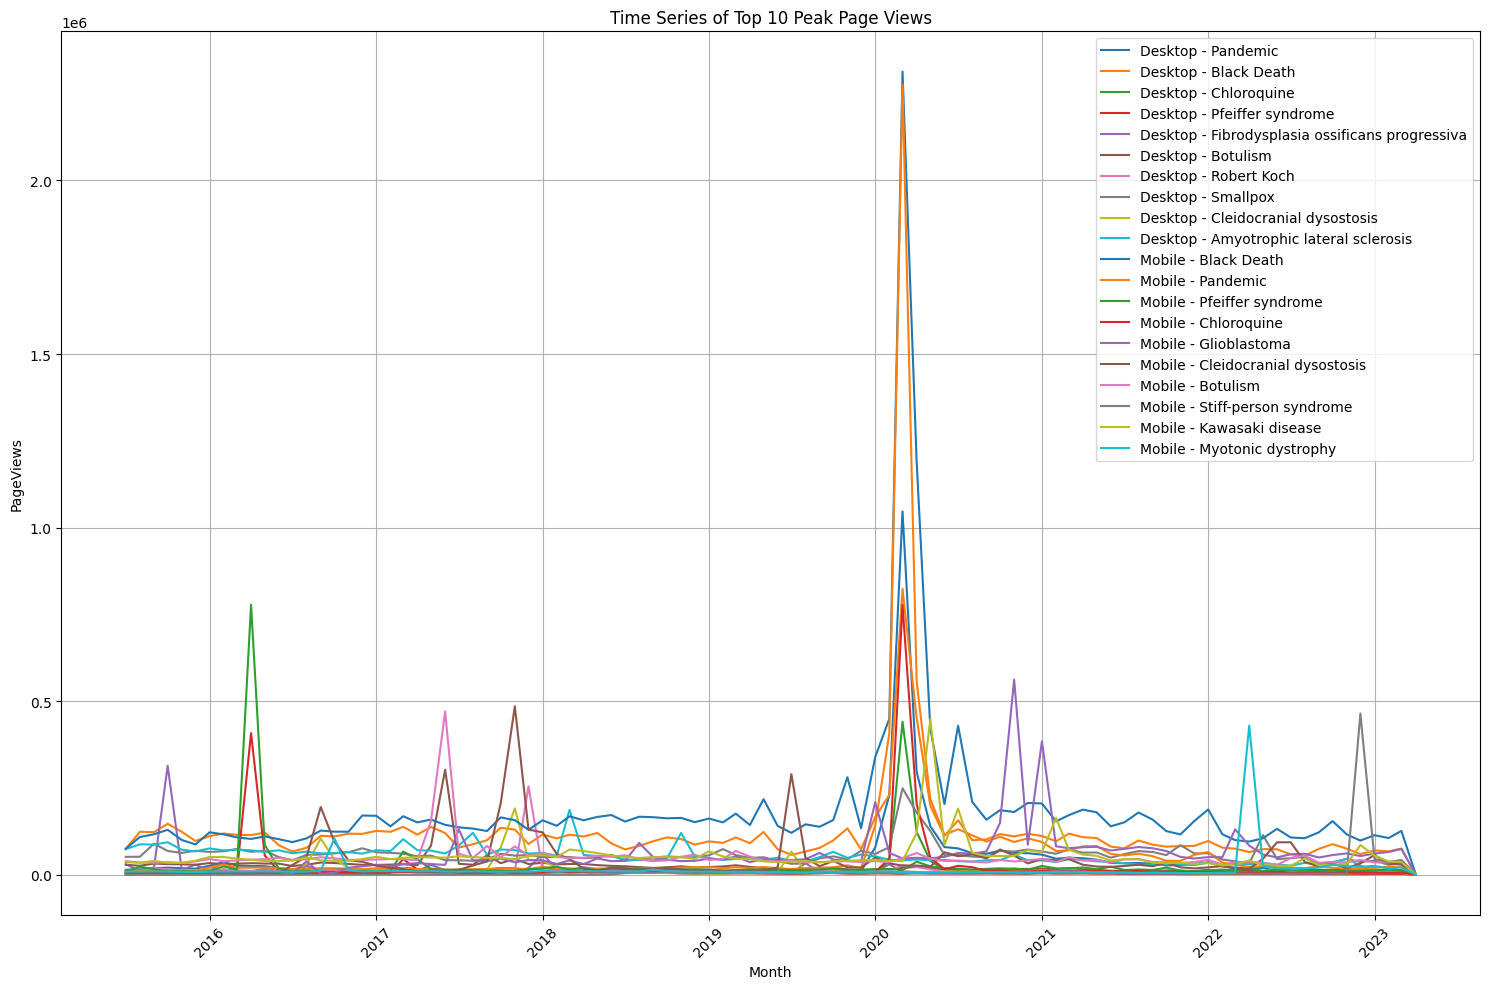

<Figure size 640x480 with 0 Axes>

In [18]:
# Find the month with the highest page views (peak) for each article for desktop access
desktop_peak_months = desktop_df.groupby("name")["views"].idxmax()
desktop_peak_data = desktop_df.loc[desktop_peak_months]

# Find the month with the highest page views (peak) for each article for mobile access
mobile_peak_months = mobile_df.groupby("name")["views"].idxmax()
mobile_peak_data = mobile_df.loc[mobile_peak_months]

# Sort articles by peak page views for desktop and mobile access
top_desktop_articles = desktop_peak_data.sort_values(by="views", ascending=False).head(10)
top_mobile_articles = mobile_peak_data.sort_values(by="views", ascending=False).head(10)

# Create the time series graph for the top 10 articles for desktop and mobile access
plt.figure(figsize=(15, 10))

# Plot top 10 desktop articles
for _, article in top_desktop_articles.iterrows():
    plt.plot(desktop_df[desktop_df["name"] == article["name"]]["timestamp"], desktop_df[desktop_df["name"] == article["name"]]["views"], label=f"Desktop - {article['name']}")

# Plot top 10 mobile articles
for _, article in top_mobile_articles.iterrows():
    plt.plot(mobile_df[mobile_df["name"] == article["name"]]["timestamp"], mobile_df[mobile_df["name"] == article["name"]]["views"], label=f"Mobile - {article['name']}")

plt.xlabel("Month")
plt.ylabel("PageViews")
plt.title("Time Series of Top 10 Peak Page Views")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('Top10PeakPageViews.png')

## Analysis 3:
Fewest Months of Data - The third graph should show pages that have the fewest months of available data. These will likely be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

Calculate the number of months for each article and then sort the by the fewest months. this is done for both mobile and desktop access.



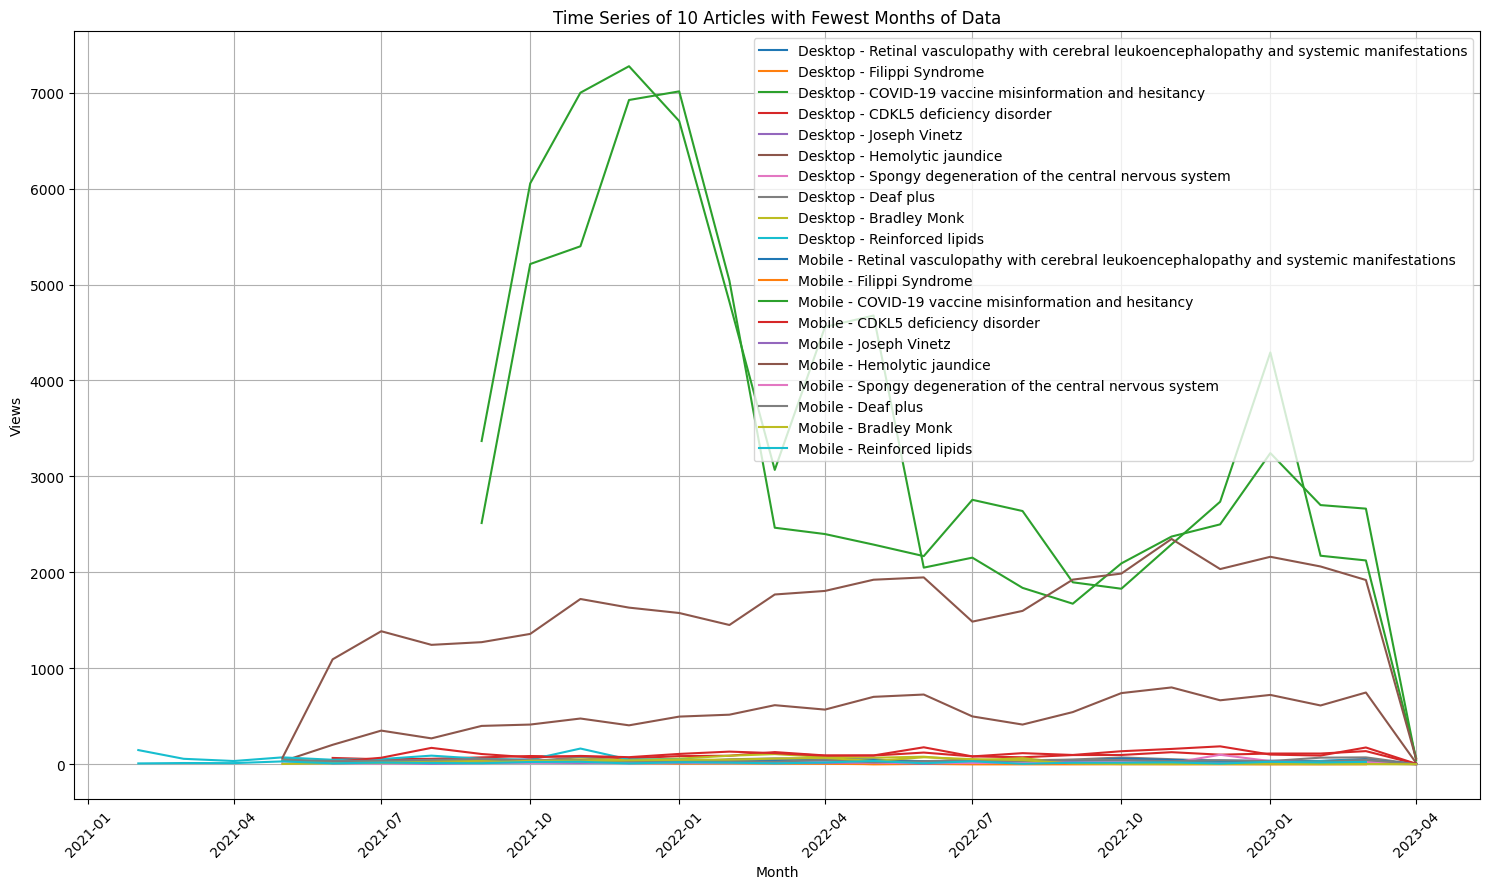

<Figure size 640x480 with 0 Axes>

In [19]:
# Calculate the number of months of data available for each article for desktop access
desktop_data_months = desktop_df.groupby("name")["timestamp"].nunique()
desktop_data_months = desktop_data_months.reset_index(name="num_months")

# Calculate the number of months of data available for each article for mobile access
mobile_data_months = mobile_df.groupby("name")["timestamp"].nunique()
mobile_data_months = mobile_data_months.reset_index(name="num_months")

# Sort articles by the fewest months of data for desktop and mobile access
top_fewest_desktop_articles = desktop_data_months.sort_values(by="num_months").head(10)
top_fewest_mobile_articles = mobile_data_months.sort_values(by="num_months").head(10)

# Create the time series graph for the 10 articles with the fewest months of data
plt.figure(figsize=(15, 9))

# Plot top 10 articles with the fewest months of data for desktop access
for _, article in top_fewest_desktop_articles.iterrows():
    plt.plot(desktop_df[desktop_df["name"] == article["name"]]["timestamp"], desktop_df[desktop_df["name"] == article["name"]]["views"], label=f"Desktop - {article['name']}")

# Plot top 10 articles with the fewest months of data for mobile access
for _, article in top_fewest_mobile_articles.iterrows():
    plt.plot(mobile_df[mobile_df["name"] == article["name"]]["timestamp"], mobile_df[mobile_df["name"] == article["name"]]["views"], label=f"Mobile - {article['name']}")

plt.xlabel("Month")
plt.ylabel("Views")
plt.title("Time Series of 10 Articles with Fewest Months of Data")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('FewestMonths.png')